# Federating a linear regression model

In this notebook we show how to use FLEXible to federate a linear regression model. We federate the linear regression algorithm provided in the [sklearn library](https://scikit-learn.org/stable/modules/clustering.html#k-means). This example is an adaption of the one provided [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html).

As usual, we first download and split the dataset we are going to use in this notebook, for simplicity we will ony use the one feature from the sklearn diabetes dataset.

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

# Load the diabetes dataset
diabetes = load_diabetes()

# Generate train-test splits
X_train, X_test, y_train, y_test = train_test_split(diabetes.data[:, np.newaxis, 2], diabetes.target, test_size=0.33, random_state=42)

Next, we federate it using FLEXible, we generate a iid distribution as follows:

In [2]:
from flex.data import FedDataDistribution, Dataset

train_diabetes = Dataset(X_train, y_train)
test_diabetes = Dataset(X_test, y_test)

federated_diabetes = FedDataDistribution.iid_distribution(train_diabetes, n_clients=5)

/Users/albertoargentedelcastillogarrido/miniforge3/envs/flex10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/albertoargentedelcastillogarrido/miniforge3/envs/flex10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <547DF619-CC59-32AF-A122-22BC22134BC2> /Users/albertoargentedelcastillogarrido/miniforge3/envs/flex10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <6384E44A-E10D-30C9-994F-E34B0519E5B3> /Users/albertoargentedelcastillogarrido/miniforge3/envs/flex10/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


Now, we present a centralized linear regression model and evaluate it, the main objective of this notebook is showing how to federate such model using FLEXible.

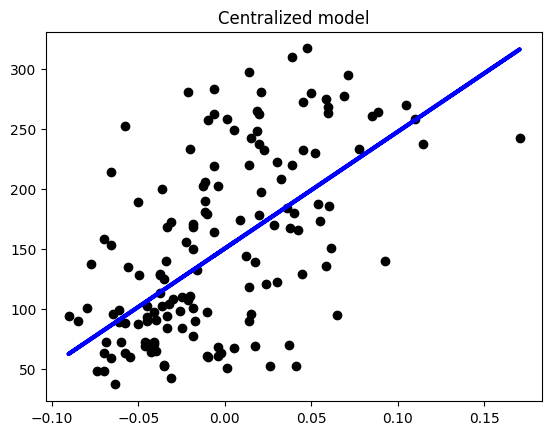

In [3]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def plot_lm(lm, test_data, title):
    preds = lm.predict(test_data.X_data)
    # Plot outputs
    plt.title(title)
    plt.scatter(test_data.X_data, test_data.y_data, color="black")
    plt.plot(test_data.X_data, preds, color="blue", linewidth=3)

    
centralized_model = LinearRegression()
centralized_model = centralized_model.fit(train_diabetes.X_data, train_diabetes.y_data)
plot_lm(centralized_model, test_diabetes, "Centralized model")

In [4]:
from sklearn import metrics
from math import sqrt

def score_model(labels, preds):
    
    rmse = sqrt(metrics.mean_squared_error(labels, preds))
    r2_score = metrics.r2_score(labels, preds)

    results = rmse, r2_score
    
    print("-----------------")
    print("RMSE: {},\nr2: {}".format(*results))
    print("-----------------")
    
print("Centralized model scores")
preds = centralized_model.predict(test_diabetes.X_data)
score_model(test_diabetes.y_data, preds)

Centralized model scores
-----------------
RMSE: 62.7221434289942,
r2: 0.3164396837685731
-----------------


## The federation process begins!

### Implementation in FLEXible

The implementation of a federated algorithm in FLEXible always begins with the same steps: 
1. Defining a function to initialize the model in the server node. Note that function `build_server_model` is decorated with decorator `init_server_model`, in this way, we only need to care about loading a model in a FlexModel object.
1. Creating an architecture, in this case, a client server architecture by means of `client_server_architecture`. Note that, the number of clients is provided in `federated_diabetes` and it can be retrieved using `len(federated_diabetes)`. 

The `FlexPool` generated contains 20 clients an 1 server, which is also an aggregator node. Remember that nodes in a `FlexPool` communicate with each other using the `map` function.

In [5]:
from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel


@init_server_model
def build_server_model():
    flex_model = FlexModel()
    flex_model.model = LinearRegression()
    return flex_model


p = FlexPool.client_server_architecture(federated_diabetes, init_func=build_server_model)

clients = p.clients
servers = p.servers
aggregators = p.aggregators

print(f"Number of nodes in the pool {len(p)}: {len(servers)} servers plus {len(clients)} clients. The server is also an aggregator")

Number of nodes in the pool 6: 1 servers plus 5 clients. The server is also an aggregator


Now, we provide a way to deploy the FlexModel in the server node to the clients node. Again, note that we decorate the function with `deploy_server_model`, so that we can focus on implementing a way of copying the server model. Thanks to the decorator, the job of copying the model in each client is done by FLEXible automagically.

In [6]:
import copy

from flex.pool import deploy_server_model

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)

servers.map(copy_server_model_to_clients, clients)

Once the models are loaded into the clients, we can proceed to train them:

In [7]:
def train(client_flex_model: FlexModel, client_data: Dataset):
    client_flex_model.model.fit(client_data.X_data, client_data.y_data)

clients.map(train)

Thanks to the decorator `collect_client_weights`, we only need to provide a way to get the trained weights of one client and FLEXible will do it for each client. Note that, in this architecture servers are the same as aggregators, therefore we can replace the last line below with: `servers.map(get_client_weights, clients)`.

In [8]:
from flex.pool import collect_clients_weights

@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    return [client_flex_model.model.intercept_, client_flex_model.model.coef_]

aggregators.map(get_clients_weights, clients)
# The same as:
# servers.map(get_client_weights, clients)

With the `aggregate_weights` decorator, we only need to implement our aggregator and FLEXible will apply it and store the result inside the FlexModel of the aggregator using internally the key "aggregated_weights". As stated before in this architecture servers are the same as aggregators, therefore we can replace the last line below with: `servers.map(aggregate)`.

In [9]:
from flex.pool import aggregate_weights
import numpy as np

@aggregate_weights
def aggregate(list_of_weights: list):
    return np.mean(np.asarray(list_of_weights, dtype=object), axis=0)

# Aggregate weights
aggregators.map(aggregate)
# The same as:
# servers.map(aggregate)

Once we have aggregated the weights, it is required to provide a way to set them in the server. The decorator `set_aggregated_weights` allow us to focus only in implementing a way to set the weights, the rest is done by FLEXible automagically.

In [10]:
from flex.pool import set_aggregated_weights

@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    server_flex_model.model.intercept_ = aggregated_weights[0]
    server_flex_model.model.coef_ = aggregated_weights[1]

# Set aggregated weights in the server model
aggregators.map(set_agreggated_weights_to_server, servers)
# The same as:
# servers.map(set_agreggated_weights_to_server, servers)

Alright, we have have completed an entire federated round so it is time to see the results. Thanks to the decorator  `evaluate_server_model` we can focus on evaluating the results of the FlexModel stored in the server node.

-----------------
RMSE: 62.76061334689504,
r2: 0.3156009186326568
-----------------


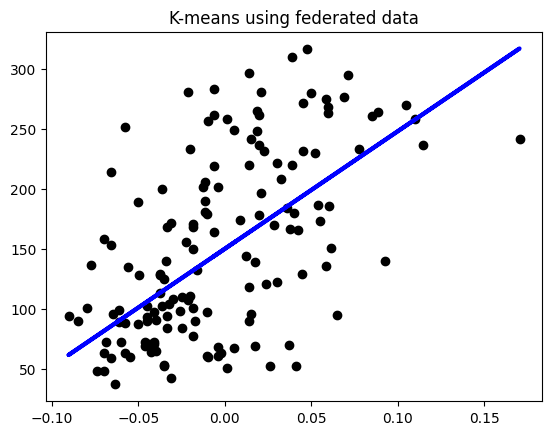

In [11]:
from flex.pool import evaluate_server_model

@evaluate_server_model
def evaluate_global_model(server_flex_model: FlexModel, test_data=None):
    preds = server_flex_model.model.predict(test_data.X_data)
    plot_lm(server_flex_model.model, test_data, title="K-means using federated data")
    score_model(test_data.y_data, preds)

servers.map(evaluate_global_model, test_data=test_diabetes)

### Run the federated learning experiment for a few rounds

Now, we can summarize the steps provided above and run the federated experiment for multiple rounds, note that in this case, we set the number of rounds to 1 since no iterations are needed in the case of linear regression. 

Federated model scores
-----------------
RMSE: 62.76061334689504,
r2: 0.3156009186326568
-----------------


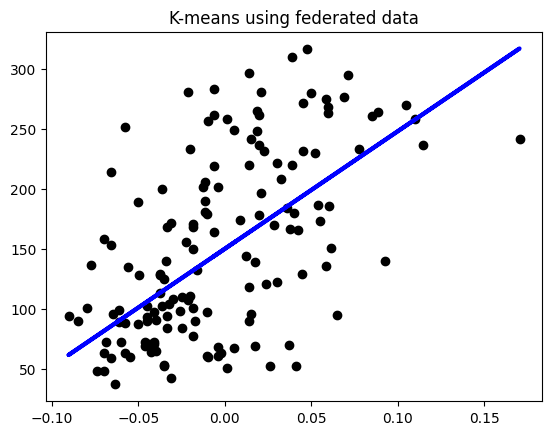

In [12]:
n_rounds = 1
p = FlexPool.client_server_architecture(federated_diabetes, init_func=build_server_model)
servers = p.servers
clients = p.clients
aggregators = p.aggregators

for i in range(n_rounds):
    servers.map(copy_server_model_to_clients, clients)
    clients.map(train)
    aggregators.map(get_clients_weights, clients)
    aggregators.map(aggregate)
    aggregators.map(set_agreggated_weights_to_server, servers)

print("Federated model scores")
servers.map(evaluate_global_model, test_data=test_diabetes)

Centralized model scores
-----------------
RMSE: 62.7221434289942,
r2: 0.3164396837685731
-----------------


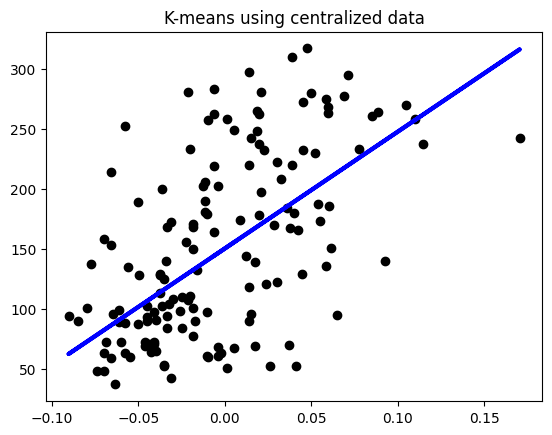

In [13]:
print("Centralized model scores")
preds = centralized_model.predict(test_diabetes.X_data)
score_model(test_diabetes.y_data, preds)
plot_lm(centralized_model, test_diabetes, title="K-means using centralized data")